##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#This code was modified from Tensorflow tutorial, MNIST classification 
#https://www.tensorflow.org/quantum/tutorials/mnist
#I used CIFAR-10 database instead of MNIST database, and I modified and tuned the original code accordingly

Import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

### 1. Load the raw data

Load the CIFAR-10 dataset distributed with Keras. 

In [72]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

train_samples = list(zip(x_train, map(int, y_train)))
test_samples = list(zip(x_test, map(int, y_test)))

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 50000
Number of original test examples: 10000


Filter the dataset to keep just the automobile and deer images (labeled with 1 and 4 respectively),  remove the other classes. 

In [73]:
def filter_type(x):
    # automobile(1) and deer(4)
    i = 0
    while i < len(x):
        if (x[i][1] != 1 & x[i][1] != 4):
            del x[i]
        else:
            i += 1       
    return x

In [74]:
train_samples = filter_type(train_samples)
test_samples = filter_type(test_samples)

print("Number of filtered training examples:", len(train_samples))
print("Number of filtered test examples:", len(test_samples))

Number of filtered training examples: 10000
Number of filtered test examples: 2000


Show the first example:

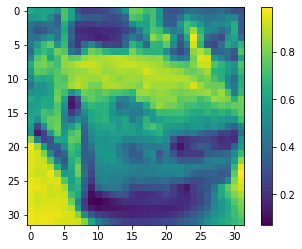

In [129]:
plt.imshow(train_samples[1][0][:,:,0])
plt.colorbar()

### 2. Downscale the images

An image size of 32x32 is much too large for current quantum computers. Resize the image down to 4x4:

In [84]:
x_train_small = list()
x_test_small = list()

for i in range(len(train_samples)):
    x_train_small.append(tf.image.resize(train_samples[i][0], (4,4)).numpy());

for i in range(len(test_samples)):
    x_test_small.append(tf.image.resize(test_samples[i][0], (4,4)).numpy());  

Show the first training example after resize: 

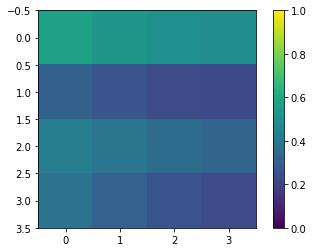

In [130]:
plt.imshow(x_train_small[1][0, :,:,0], vmin=0, vmax=1)
plt.colorbar()

### 3. Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [135]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x[1]
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x[1])
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    return np.array(new_x), np.array(new_y)

In [133]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

In [136]:
x_test_small, y_test = remove_contradicting(x_train_small, y_test)

### 4. Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [109]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [110]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    # print(len(values))
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

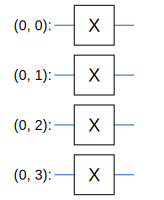

In [111]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [113]:
bin_img = x_train_bin[0,:, :,0]
indices = np.array(np.where(bin_img)).T
indices

array([[0],
       [1],
       [2],
       [3]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [114]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

### 5. Build the model circuit for Quantum Neural Network

This following example shows a layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [115]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

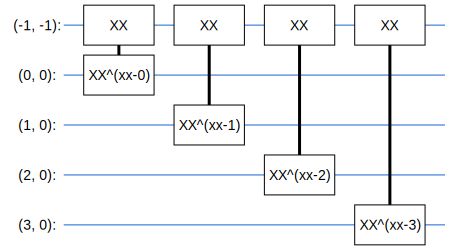

In [116]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [117]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

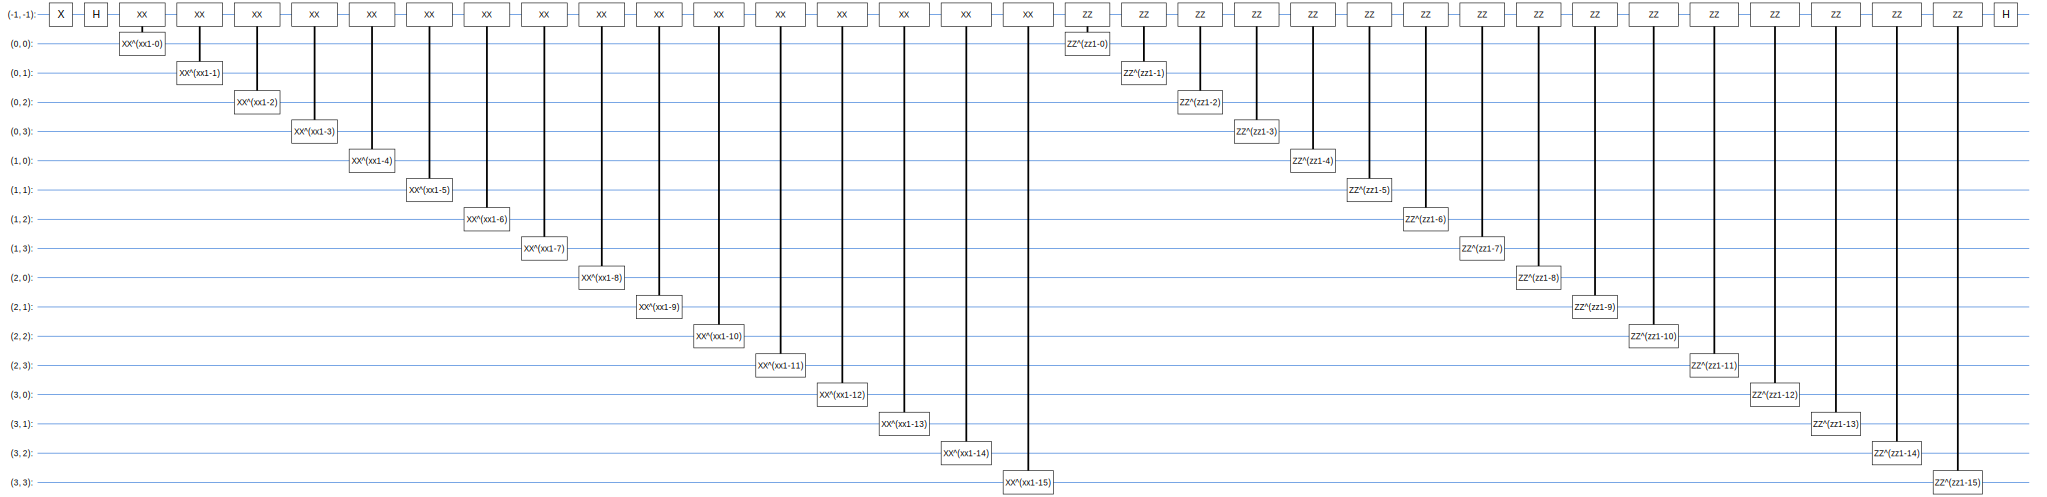

In [34]:
model_circuit, model_readout = create_quantum_model()
SVGCircuit(model_circuit)

### 6. Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [118]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [119]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [120]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [121]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [122]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### 7. Train and test the quantum model

In [123]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = 1500 # len(x_train_tfcirc)

In [124]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [125]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
47/47 [==============================] - 41s 877ms/step - loss: 0.6194 - hinge_accuracy: 0.9034 - val_loss: 0.3328 - val_hinge_accuracy: 0.9000
Epoch 2/3
47/47 [==============================] - 40s 865ms/step - loss: 0.3074 - hinge_accuracy: 0.8978 - val_loss: 0.2461 - val_hinge_accuracy: 0.9000
Epoch 3/3
313/313 [==============================] - 25s 80ms/step - loss: 0.2560 - hinge_accuracy: 0.9000


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

The result accuracy is shown below as a bar plot. It is shown to have 90% accuracy over the test data.

/Users/hyunjinkim/opt/anaconda3/envs/qiskit_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

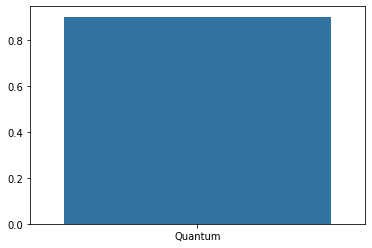

In [128]:
qnn_accuracy = qnn_results[1]
sns.barplot(["Quantum"], [qnn_accuracy])